In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

: 

# IMPORT lib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

: 

In [2]:
torch.manual_seed(42)

In [6]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10
input_size = 28 * 28  # Flattened 28x28 images
hidden_size = 128
num_classes = 10

In [7]:
# 1. Load and Preprocess the Data
# Define transformations (normalization and conversion to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [11]:
# Load Fashion MNIST dataset
# Note: If the dataset is not available locally, it will be downloaded
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 266kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 10.1MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [12]:
# Create data loaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
# Fashion MNIST class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:


# 2. Define the Neural Network Model
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = FeedforwardNN(input_size, hidden_size, num_classes)

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# 3. Train and Evaluate the Model

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    train_accs = []
    
    start_time = time.time()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    training_time = time.time() - start_time
    print(f'Training completed in {training_time:.2f} seconds')
    return train_losses, train_accs


In [17]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1
                
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Print accuracy for each class
    for i in range(num_classes):
        class_acc = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of {class_labels[i]}: {class_acc:.2f}%')
    
    return accuracy, class_correct, class_total


In [18]:
# Function to visualize some examples
def show_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(12, 3))
    for i in range(num_examples):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        img = img.squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{class_labels[label]}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
# Function to visualize training progress
def plot_training_progress(losses, accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(losses, 'b-')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot(accuracies, 'r-')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()


In [20]:
# Function to visualize confusion matrix
def plot_confusion_matrix(model, test_loader):
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(int(confusion_matrix[i, j]), fmt),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Displaying sample images from the dataset:


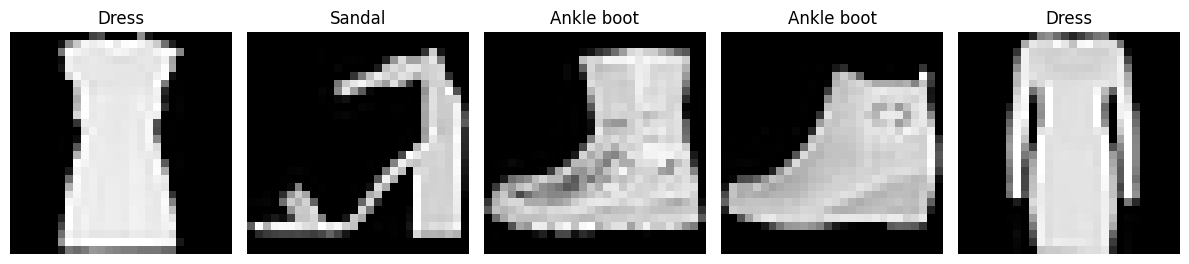

In [22]:
# Show some examples from the dataset
print("Displaying sample images from the dataset:")
show_examples(train_dataset)


In [23]:
# Train the model
print("\nStarting model training...")
train_losses, train_accs = train_model(model, train_loader, criterion, optimizer, num_epochs)



Starting model training...
Epoch [1/10], Loss: 0.5110, Accuracy: 81.33%
Epoch [2/10], Loss: 0.3764, Accuracy: 86.22%
Epoch [3/10], Loss: 0.3402, Accuracy: 87.25%
Epoch [4/10], Loss: 0.3122, Accuracy: 88.42%
Epoch [5/10], Loss: 0.2917, Accuracy: 89.12%
Epoch [6/10], Loss: 0.2784, Accuracy: 89.62%
Epoch [7/10], Loss: 0.2642, Accuracy: 90.09%
Epoch [8/10], Loss: 0.2495, Accuracy: 90.64%
Epoch [9/10], Loss: 0.2423, Accuracy: 90.92%
Epoch [10/10], Loss: 0.2309, Accuracy: 91.21%
Training completed in 142.74 seconds


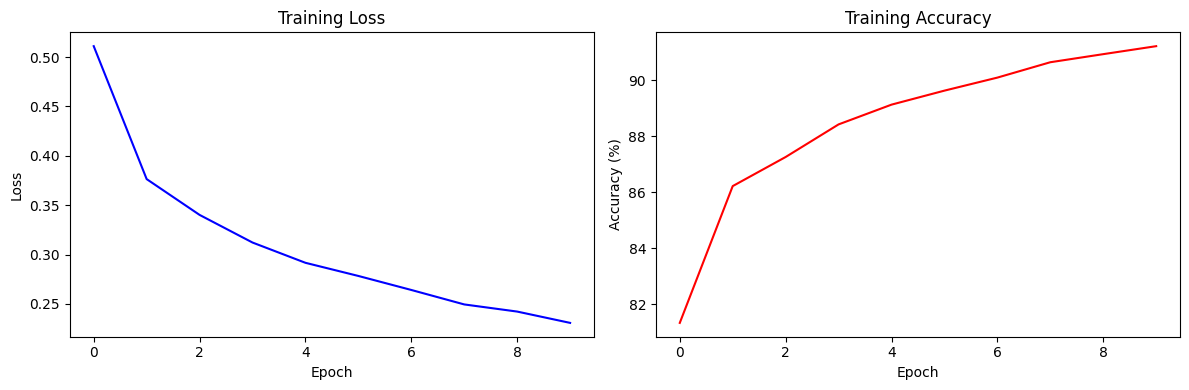

In [24]:
# Plot training progress
plot_training_progress(train_losses, train_accs)

In [25]:
# Evaluate the model on test data
print("\nEvaluating model on test data:")
test_accuracy, class_correct, class_total = evaluate_model(model, test_loader)



Evaluating model on test data:
Test Accuracy: 88.22%
Accuracy of T-shirt/top: 81.50%
Accuracy of Trouser: 96.00%
Accuracy of Pullover: 83.50%
Accuracy of Dress: 93.40%
Accuracy of Coat: 78.60%
Accuracy of Sandal: 94.90%
Accuracy of Shirt: 67.40%
Accuracy of Sneaker: 95.30%
Accuracy of Bag: 96.30%
Accuracy of Ankle boot: 95.30%



Generating confusion matrix:


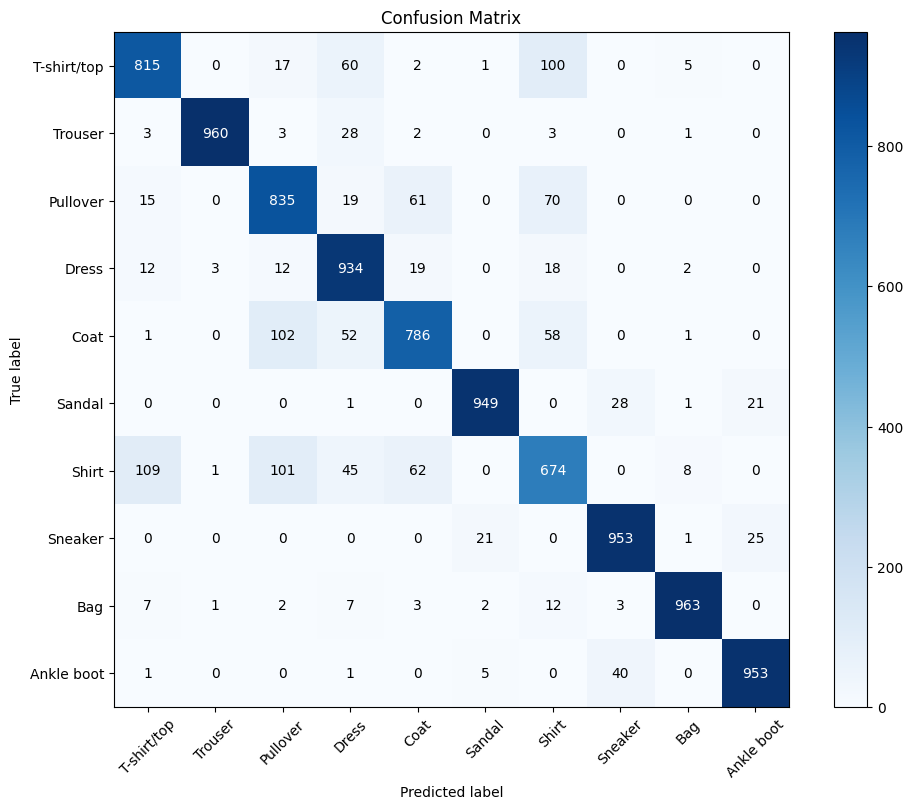

In [26]:
# Visualize confusion matrix
print("\nGenerating confusion matrix:")
plot_confusion_matrix(model, test_loader)


In [ ]:
# Save the model
torch.save(model.state_dict(), 'fashion_mnist_ann.pth')
print("\nModel saved to 'fashion_mnist_ann.pth'")